In [6]:
# Import necessary libraries
#!pip install aif360==0.2.2

In [7]:
#!pip install cvxpy

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score



In [9]:
from aif360.datasets import AdultDataset, StandardDataset

## Initial Performance and Fairness Metric

Statistical Parity Difference: -0.1989
Disparate impact is : 0.2478

OverallBase Rate is : 0.3635
Base rate for the privileged group = 0.3125
Base rate for the unprivileged group = 0.1136


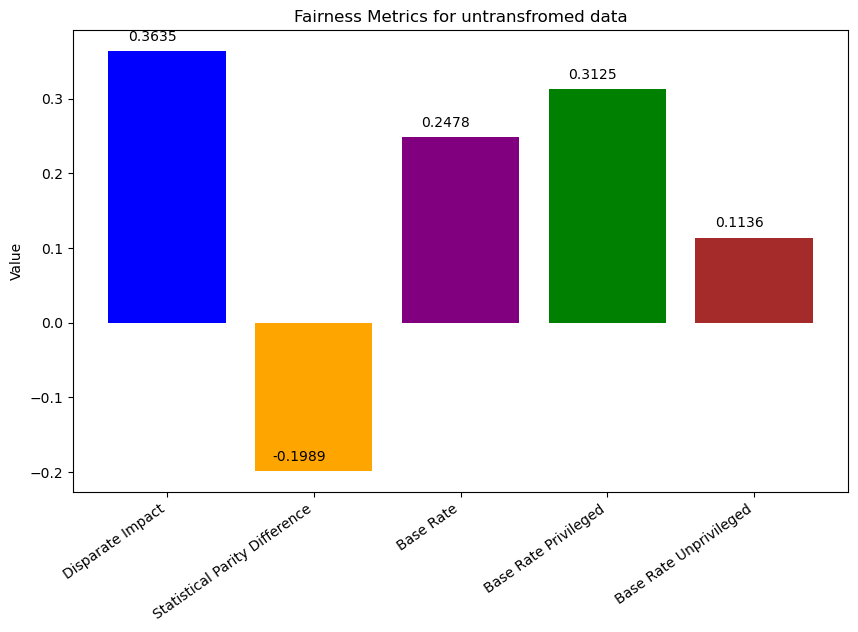

In [10]:

label_map = {1.0: '>50K', 0.0: '<=50K'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

ad = AdultDataset(
    protected_attribute_names=['sex'],
    categorical_features=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country', 'race']
    ,features_to_drop=['fnlwgt'],privileged_classes=[['Male']],
    metadata={'label_map': label_map, 'protected_attribute_maps': protected_attribute_maps}
)


metric = BinaryLabelDatasetMetric(ad, privileged_groups=[{'sex': 1.0}], unprivileged_groups=[{'sex': 0.0}])
statistical_parity_diff = metric.mean_difference()
print("Statistical Parity Difference: {:.4f}".format(statistical_parity_diff))
Base_rate = metric.base_rate()

num_postive= metric.num_positives()
#print("Number of positive is : {:.4f}".format(num_postive))
base_rate_priv = metric.base_rate(privileged=True)
base_rate_unpriv = metric.base_rate(privileged=False)
disparate_impact = metric.disparate_impact()
print("Disparate impact is : {:.4f}".format(Base_rate))
print('')
print("OverallBase Rate is : {:.4f}".format(disparate_impact))
print("Base rate for the privileged group = {:.4f}".format(base_rate_priv))
print("Base rate for the unprivileged group = {:.4f}".format(base_rate_unpriv))
metrics = ['Disparate Impact', 'Statistical Parity Difference', 'Base Rate', 'Base Rate Privileged', 'Base Rate Unprivileged' ]
values = [disparate_impact,statistical_parity_diff, Base_rate, base_rate_priv, base_rate_unpriv]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'purple', 'green', 'brown'])

# Add labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

# Set rotation for x-axis labels
plt.xticks(rotation=35, ha='right')

plt.ylabel('Value')
plt.title('Fairness Metrics for untransfromed data')
plt.show()

In [11]:
# Split original data into train and test data
train_orig, val_orig = ad.split([0.70], np.random.seed(42))
val_orig, test_orig= val_orig.split([0.5], np.random.seed(42))
train_orig_df, _ = train_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()
val_orig_df,_=val_orig.convert_to_dataframe()
X_test = test_orig_df.drop("income-per-year", axis=1)
Y_test = test_orig_df["income-per-year"]
# Use the shape function to output the size of each of the dataframes below
print("Train set: ", train_orig_df.shape)
print("Test set: ", test_orig_df.shape)
print("Test set: ", val_orig_df.shape)
print(X_test.dtypes)

Train set:  (31655, 103)
Test set:  (6784, 103)
Test set:  (6783, 103)
age                               float64
education-num                     float64
sex                               float64
capital-gain                      float64
capital-loss                      float64
                                   ...   
native-country=Thailand           float64
native-country=Trinadad&Tobago    float64
native-country=United-States      float64
native-country=Vietnam            float64
native-country=Yugoslavia         float64
Length: 102, dtype: object


In [12]:
metric_1 = BinaryLabelDatasetMetric(train_orig, privileged_groups=[{'sex': 1}], unprivileged_groups=[{'sex': 0}])
statistical_parity_diff = metric_1.statistical_parity_difference()
print("Statistical Parity Difference in training data: {:.4f}".format(statistical_parity_diff))
Base_rate = metric_1.base_rate()
print("Base Rate is in training data: {:.4f}".format(Base_rate))
num_postive= metric_1.num_positives()
print("Number of positive in training data : {:.4f}".format(num_postive))
base_rate_priv = metric_1.base_rate(privileged=True)
base_rate_unpriv = metric_1.base_rate(privileged=False)
print("Base rate for the privileged group in training data = %f" % base_rate_priv)
print("Base rate for the unprivileged group in training data= %f" % base_rate_unpriv)

Statistical Parity Difference in training data: -0.1977
Base Rate is in training data: 0.2463
Number of positive in training data : 7796.0000
Base rate for the privileged group in training data = 0.310595
Base rate for the unprivileged group in training data= 0.112859


In [13]:
x_train = train_orig_df.drop("income-per-year", axis=1)
y_train = train_orig_df["income-per-year"]
print("Outcomes: ")
y_train.value_counts()

Outcomes: 


income-per-year
0.0    23859
1.0     7796
Name: count, dtype: int64

In [14]:
privileged_group=[{'sex': 1}]
unprivileged_group=[{'sex': 0}]
metric_orig_train = BinaryLabelDatasetMetric(train_orig, 
                                             privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.197736


In [15]:
RW = Reweighing(unprivileged_groups=unprivileged_group,
               privileged_groups=privileged_group)
RW.fit(train_orig)
dataset_transf_train = RW.transform(train_orig)

In [16]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-train_orig.instance_weights.sum())<1e-6

In [17]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)
print("Statistical Parity between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
print("Base rate of privileged groups = %f" % metric_transf_train.base_rate(privileged=True))
print("Base rate of privileged groups = %f" % metric_transf_train.base_rate(privileged=False))

Statistical Parity between unprivileged and privileged groups = -0.000000
Base rate of privileged groups = 0.246280
Base rate of privileged groups = 0.246280


In [18]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

In [19]:
#!pip install tabulate
from tabulate import tabulate

In [20]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(train_orig.features)
y_train = train_orig.labels.ravel()
w_train = train_orig.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=None)
coefficients = lmod.coef_
intercept = lmod.intercept_
feature_names= ad.feature_names


coefficients_flat = coefficients.flatten()

# Combine coefficients with feature names
coefficients_with_names = list(zip(feature_names, coefficients_flat))

# Sort coefficients in descending order
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)

# Add an index column to the sorted coefficients
indexed_coefficients = [(index + 1, *row) for index, row in enumerate(sorted_coefficients)]

# Convert the indexed coefficients to a list of lists
table_data = [list(row) for row in indexed_coefficients]

# Create a table
table = tabulate(table_data, headers=["Rank", "Feature", "Coefficient"], tablefmt="fancy_grid")

# Display the table
print(table)


y_train_pred = lmod.predict(X_train)
y_test_pred= lmod.predict(X_test)
misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(Y_test, y_test_pred)) if true_label != pred_label]
print(len(misclassified_indices))
# positive class index
pos_ind = np.where(lmod.classes_ == train_orig.favorable_label)[0][0]

dataset_orig_train_pred = train_orig.copy()
dataset_orig_train_pred.labels = y_train_pred

╒════════╤═══════════════════════════════════════════╤═══════════════╕
│   Rank │ Feature                                   │   Coefficient │
╞════════╪═══════════════════════════════════════════╪═══════════════╡
│      1 │ capital-gain                              │    2.3012     │
├────────┼───────────────────────────────────────────┼───────────────┤
│      2 │ marital-status=Married-civ-spouse         │    0.796314   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      3 │ marital-status=Never-married              │   -0.544556   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      4 │ education-num                             │    0.34424    │
├────────┼───────────────────────────────────────────┼───────────────┤
│      5 │ hours-per-week                            │    0.33426    │
├────────┼───────────────────────────────────────────┼───────────────┤
│      6 │ age                                       │    0.320238   │
├─────

c:\Users\njahi\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [21]:
dataset_orig_valid_pred = val_orig.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = test_orig.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [22]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(val_orig,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.8239
Optimal classification threshold (no reweighing) = 0.2674


In [23]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp=False):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()

    # Calculate true positive and true negative counts for privileged and unprivileged groups
    metrics["True positive count (privileged)"] = classified_metric_pred.num_true_positives(privileged=True)
    metrics["True positive count (unprivileged)"] = classified_metric_pred.num_true_positives(privileged=False)
    metrics["True negative count (privileged)"] = classified_metric_pred.num_true_negatives(privileged=True)
    metrics["True negative count (unprivileged)"] = classified_metric_pred.num_true_negatives(privileged=False)

    # Calculate false positive and false negative counts for privileged and unprivileged groups
    metrics["False positive count (privileged)"] = classified_metric_pred.num_false_positives(privileged=True)
    metrics["False positive count (unprivileged)"] = classified_metric_pred.num_false_positives(privileged=False)
    metrics["False negative count (privileged)"] = classified_metric_pred.num_false_negatives(privileged=True)
    metrics["False negative count (unprivileged)"] = classified_metric_pred.num_false_negatives(privileged=False)

    # Calculate other fairness metrics
    metrics["Balanced accuracy"] = 0.5 * (classified_metric_pred.true_positive_rate() +
                                          classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics


In [24]:
from tqdm import tqdm

stat_parity_arr = []
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []
#true_pos_num_pri = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(test_orig, dataset_orig_test_pred, 
                                      unprivileged_group, privileged_group,
                                      disp=disp)
    stat_parity_arr.append(metric_test_bef["Statistical parity difference"])
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    #true_pos_num_pri.append(metric_test_bef["True positive count (privileged)"])



Classification threshold used = 0.2674


  9%|▉         | 9/100 [00:00<00:01, 85.07it/s]

 43%|████▎     | 43/100 [00:00<00:00, 94.98it/s] 

True positive count (privileged) = 1265.0000
True positive count (unprivileged) = 184.0000
True negative count (privileged) = 2301.0000
True negative count (unprivileged) = 1807.0000
False positive count (privileged) = 833.0000
False positive count (unprivileged) = 112.0000
False negative count (privileged) = 202.0000
False negative count (unprivileged) = 80.0000
Balanced accuracy = 0.8250
Statistical parity difference = -0.3204
Disparate impact = 0.2974
Average odds difference = -0.1864
Equal opportunity difference = -0.1653


100%|██████████| 100/100 [00:01<00:00, 93.52it/s]


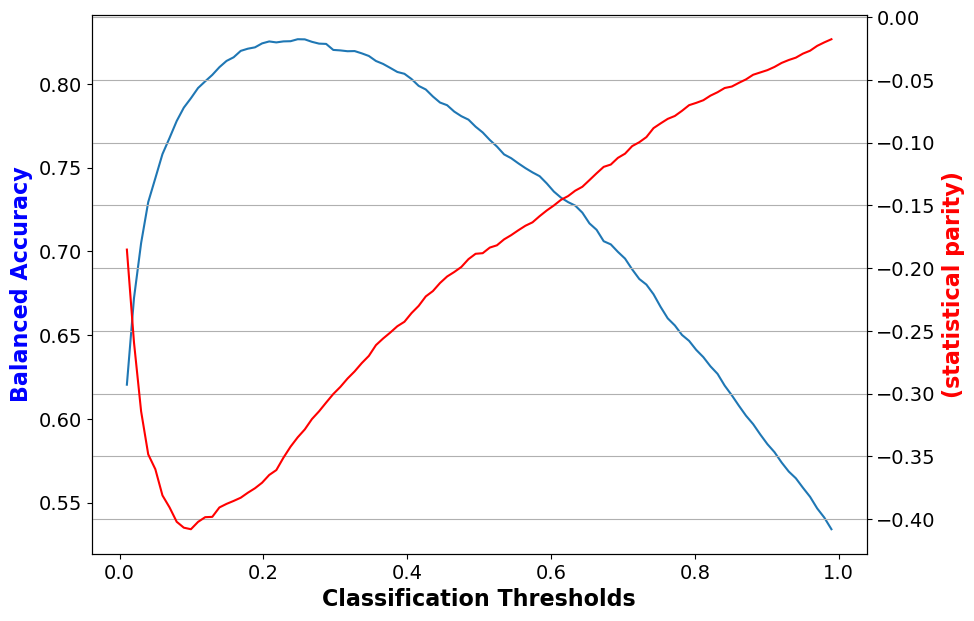

In [25]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_parity_arr, color='r')
ax2.set_ylabel('(statistical parity)', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

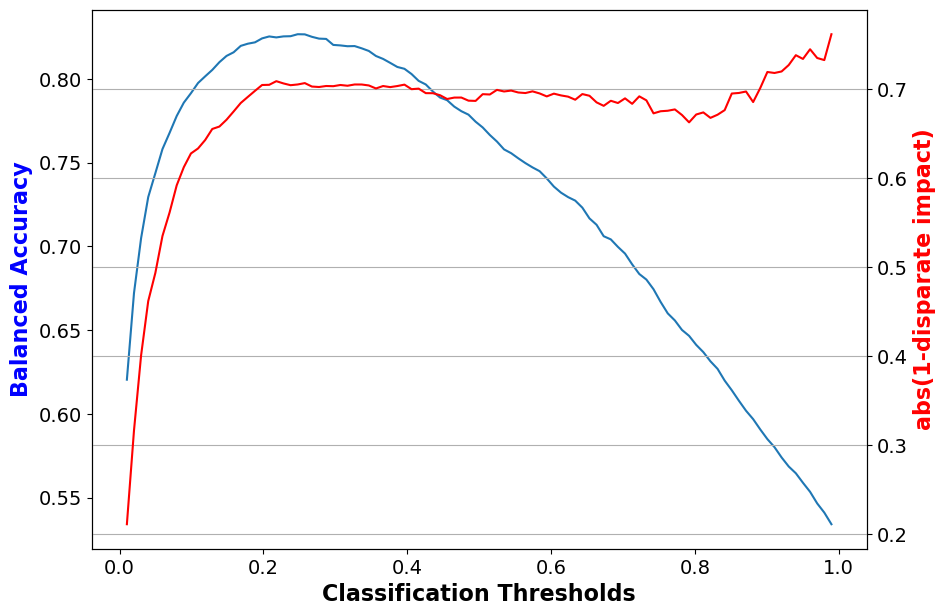

In [26]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

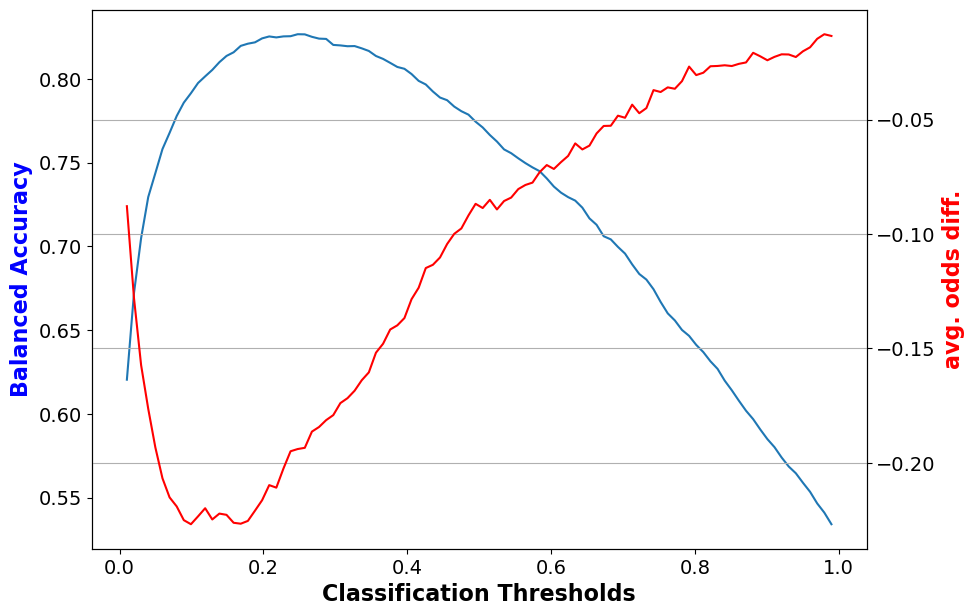

In [27]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

True positive count (privileged) = 1003.0000
True positive count (unprivileged) = 149.0000
True negative count (privileged) = 2742.0000
True negative count (unprivileged) = 1863.0000
False positive count (privileged) = 392.0000
False positive count (unprivileged) = 56.0000
False negative count (privileged) = 464.0000
False negative count (unprivileged) = 115.0000
Balanced accuracy = 0.7884
Statistical parity difference = -0.2093
Disparate impact = 0.3097
Average odds difference = -0.1076
Equal opportunity difference = -0.1193


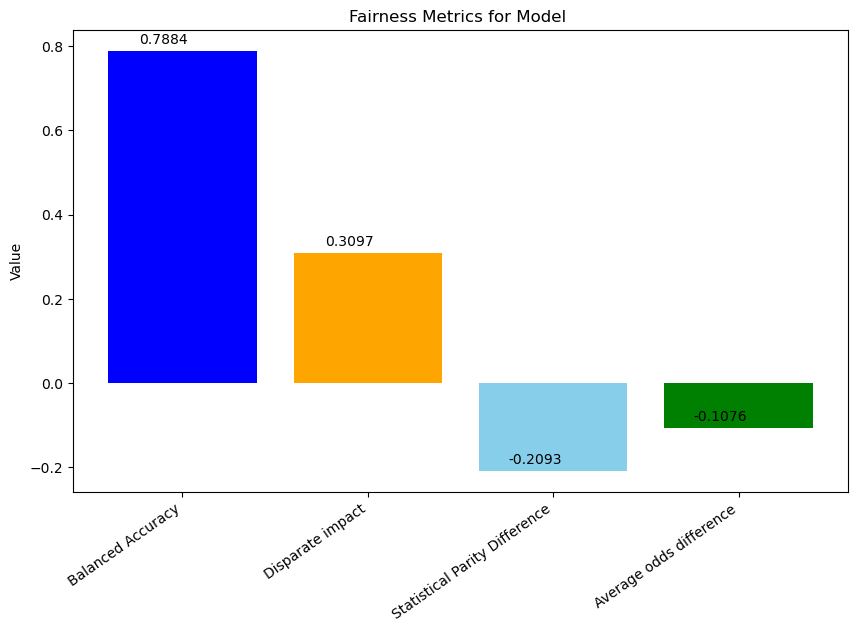

In [28]:
thresh= 0.45
#print('Classification Threshold is : ', thresh)   
fav_inds = dataset_orig_test_pred.scores > thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
metric_test_bef = compute_metrics(test_orig, dataset_orig_test_pred, 
                                      unprivileged_group, privileged_group,
                                      disp = True)
stat_parity_arr=metric_test_bef["Statistical parity difference"]
bal_acc_arr_orig=metric_test_bef["Balanced accuracy"]
avg_odds_diff_arr_orig=metric_test_bef["Average odds difference"]
disp_imp_arr_orig=metric_test_bef["Disparate impact"]
metrics = ['Balanced Accuracy', 'Disparate impact', 'Statistical Parity Difference','Average odds difference' ]
values = [bal_acc_arr_orig , disp_imp_arr_orig,stat_parity_arr, avg_odds_diff_arr_orig]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'skyblue', 'green'])

# Add labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

# Set rotation for x-axis labels
plt.xticks(rotation=35, ha='right')

plt.ylabel('Value')
plt.title('Fairness Metrics for Model ')
plt.show()

In [29]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)

y_train_pred = lmod.predict(X_train)
y_test_pred = lmod.predict(X_test)



In [30]:
coefficients=lmod.coef_
coefficients_flat = coefficients.flatten()
# Combine coefficients with feature names
coefficients_with_names = list(zip(feature_names, coefficients_flat))

# Sort coefficients in descending order
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]), reverse=True)

# Add an index column to the sorted coefficients
indexed_coefficients = [(index + 1, *row) for index, row in enumerate(sorted_coefficients)]

# Convert the indexed coefficients to a list of lists
table_data = [list(row) for row in indexed_coefficients]

# Create a table
table = tabulate(table_data, headers=["Rank", "Feature", "Coefficient"], tablefmt="fancy_grid")

# Display the table
print(table)

╒════════╤═══════════════════════════════════════════╤═══════════════╕
│   Rank │ Feature                                   │   Coefficient │
╞════════╪═══════════════════════════════════════════╪═══════════════╡
│      1 │ capital-gain                              │    2.3131     │
├────────┼───────────────────────────────────────────┼───────────────┤
│      2 │ marital-status=Married-civ-spouse         │    0.838529   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      3 │ marital-status=Never-married              │   -0.568869   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      4 │ education-num                             │    0.356466   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      5 │ hours-per-week                            │    0.344984   │
├────────┼───────────────────────────────────────────┼───────────────┤
│      6 │ age                                       │    0.331514   │
├─────

## Test transfromed model with untransformed test data

In [31]:
dataset_transf_test_pred = test_orig.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
y_test_pred= lmod.predict(X_test)
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
correctly_classified_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_test, y_test_pred)) if true_label == pred_label]
print(len(correctly_classified_indices))
misclassified_to_correct_indices = list(set(misclassified_indices) & set(correctly_classified_indices))
print(len(misclassified_to_correct_indices))
print("Indices initially misclassified but correctly classified after transformation:", misclassified_to_correct_indices)

5697
4710
Indices initially misclassified but correctly classified after transformation: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 46, 47, 50, 52, 53, 54, 57, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 72, 73, 74, 75, 78, 81, 82, 85, 88, 89, 91, 92, 93, 94, 96, 97, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 117, 119, 122, 123, 124, 126, 127, 128, 129, 131, 132, 134, 135, 136, 137, 138, 140, 141, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 175, 177, 178, 179, 180, 185, 186, 188, 190, 192, 197, 198, 199, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 213, 217, 218, 220, 221, 222, 223, 224, 226, 227, 228, 229, 231, 232, 233, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 254, 257, 258, 259, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 277, 

In [32]:
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
stat_parity_arr_transf=[]

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(test_orig, dataset_transf_test_pred, 
                                      unprivileged_group, privileged_group,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    stat_parity_arr_transf.append(metric_test_aft["Statistical parity difference"])

Classification threshold used = 0.2674


 38%|███▊      | 38/100 [00:00<00:00, 93.17it/s]

True positive count (privileged) = 1164.0000
True positive count (unprivileged) = 219.0000
True negative count (privileged) = 2527.0000
True negative count (unprivileged) = 1677.0000
False positive count (privileged) = 607.0000
False positive count (unprivileged) = 242.0000
False negative count (privileged) = 303.0000
False negative count (unprivileged) = 45.0000
Balanced accuracy = 0.8155
Statistical parity difference = -0.1737
Disparate impact = 0.5486
Average odds difference = -0.0157
Equal opportunity difference = 0.0361


100%|██████████| 100/100 [00:01<00:00, 84.54it/s]


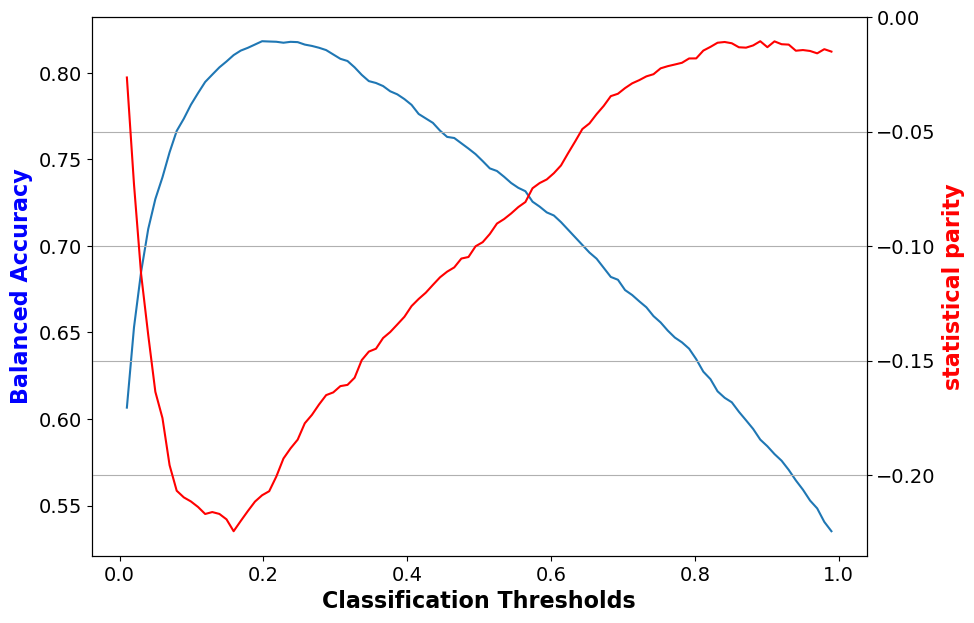

In [33]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, stat_parity_arr_transf, color='r')
ax2.set_ylabel('statistical parity', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

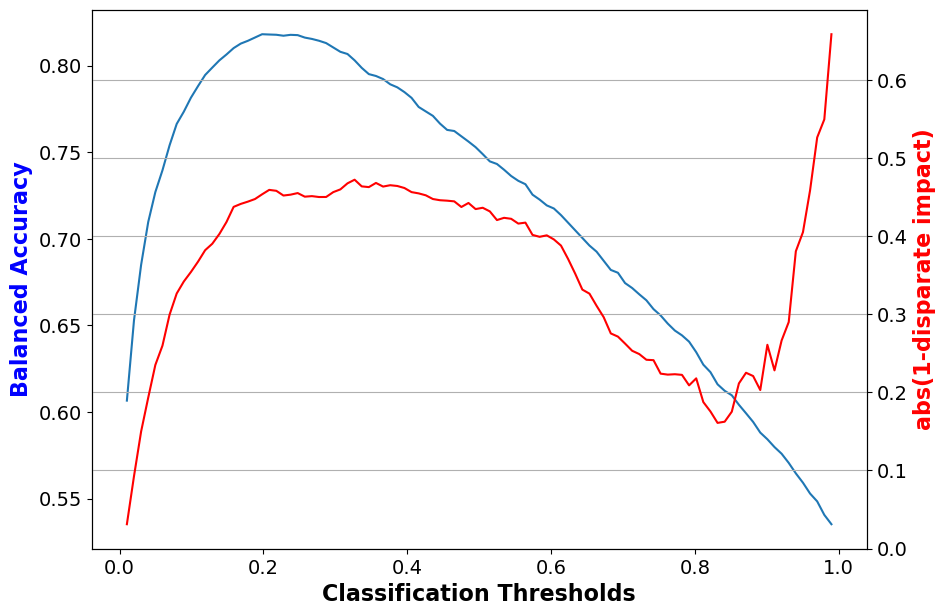

In [34]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

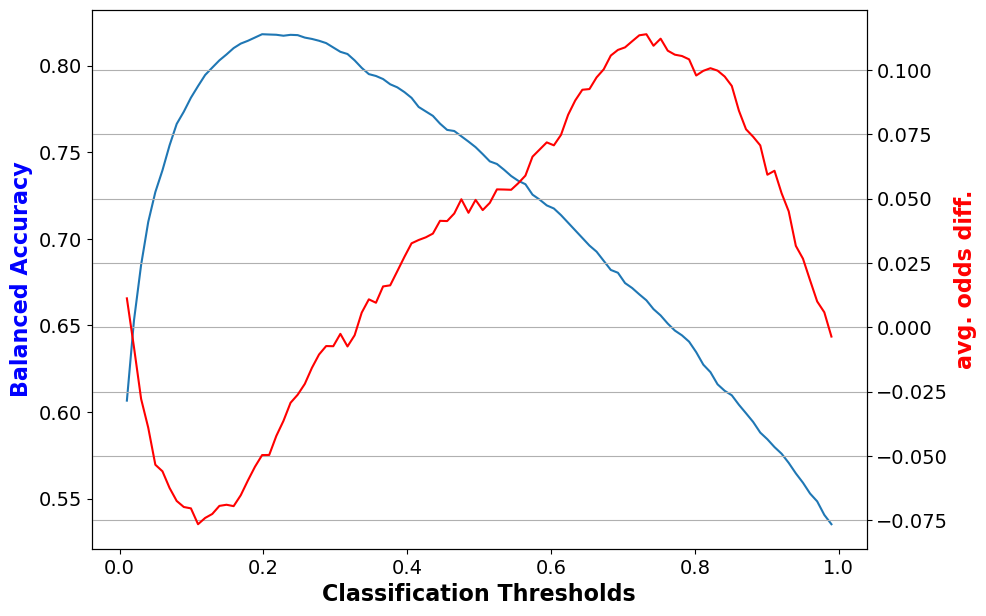

In [35]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
#ax2.axvline(0.5, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

Classification Threshold is :  0.52
True positive count (privileged) = 782.0000
True positive count (unprivileged) = 172.0000
True negative count (privileged) = 2918.0000
True negative count (unprivileged) = 1820.0000
False positive count (privileged) = 216.0000
False positive count (unprivileged) = 99.0000
False negative count (privileged) = 685.0000
False negative count (unprivileged) = 92.0000
Balanced accuracy = 0.7444
Statistical parity difference = -0.0928
Disparate impact = 0.5723
Average odds difference = 0.0506
Equal opportunity difference = 0.1185


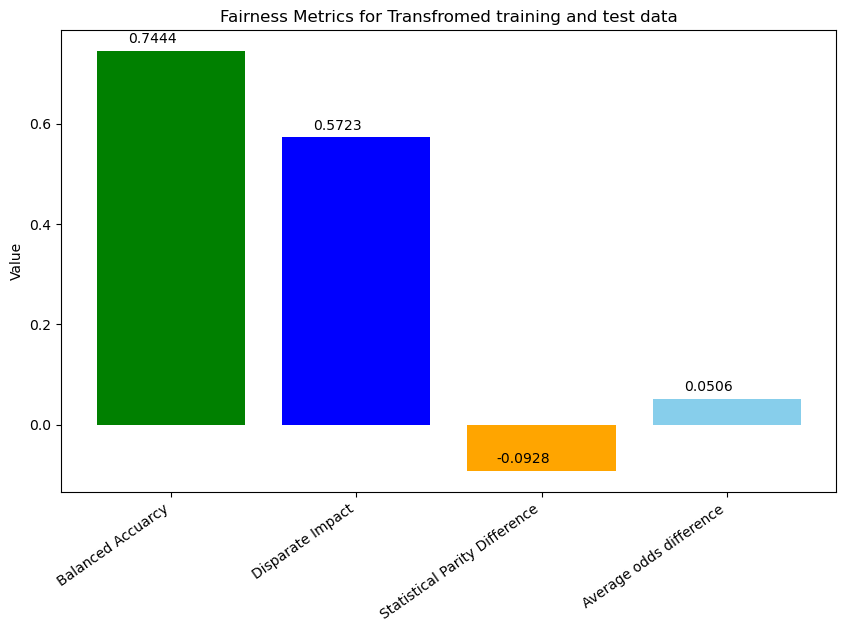

In [36]:
thresh=0.52
print('Classification Threshold is : ', thresh)  
fav_inds = dataset_transf_test_pred.scores > thresh
dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
metric_test_aft = compute_metrics(test_orig, dataset_transf_test_pred, 
                                      unprivileged_group, privileged_group,
                                      disp = True)
stat_parity_arr=metric_test_aft["Statistical parity difference"]
bal_acc_arr_orig=metric_test_aft["Balanced accuracy"]
avg_odds_diff_arr_orig=metric_test_aft["Average odds difference"]
disp_imp_arr_orig=metric_test_aft["Disparate impact"]
metrics = ['Balanced Accuarcy','Disparate Impact', 'Statistical Parity Difference', 'Average odds difference']
values = [bal_acc_arr_orig, disp_imp_arr_orig, stat_parity_arr, avg_odds_diff_arr_orig]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['green','blue', 'orange', 'skyblue', 'red'])

# Add labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{value:.4f}', ha='center', va='bottom')

# Set rotation for x-axis labels
plt.xticks(rotation=35, ha='right')

plt.ylabel('Value')
plt.title('Fairness Metrics for Transfromed training and test data')
plt.show()